In [1]:
# The following codes are from Stanford CS231N Study
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [17]:
import h5py

BASE_DIR = 'cs231n/datasets/coco_captioning'

def load_coco_data(base_dir=BASE_DIR,
                   max_train=None,
                   pca_features=True):
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)

    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['%s_captions' % split].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['%s_captions' % split][mask]
    image_idxs = data['%s_image_idxs' % split][mask]
    image_features = data['%s_features' % split][image_idxs]
    urls = data['%s_urls' % split][image_idxs]
    return captions, image_features, urls

def lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b):
    """
    Forward pass for a single timestep of an LSTM.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Note that a sigmoid() function has already been provided for you in this file.

    Inputs:
    - x: Input data, of shape (N, D)
    - prev_h: Previous hidden state, of shape (N, H)
    - prev_c: previous cell state, of shape (N, H)
    - Wx: Input-to-hidden weights, of shape (D, 4H)
    - Wh: Hidden-to-hidden weights, of shape (H, 4H)
    - b: Biases, of shape (4H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - next_c: Next cell state, of shape (N, H)
    - cache: Tuple of values needed for backward pass.
    """
    next_h, next_c, cache = None, None, None
    N,D = np.shape(x)
    _,H = np.shape(prev_h)
    tmp = np.dot(x,Wx) + np.dot(prev_h,Wh) + b
    inp = sigmoid(tmp[:,0:H]) 
    forget = sigmoid(tmp[:,H:2*H])
    out = sigmoid(tmp[:,2*H:3*H])
    gate = np.tanh(tmp[:,3*H:])
    next_c = prev_c * forget + inp*gate    # (N,H)
    next_h = out * np.tanh(next_c)
    cache = inp,forget,out,gate,x,prev_h, prev_c,Wx,Wh,b,next_c,next_h
    
    pass
    return next_h, next_c, cache


def lstm_step_backward(dnext_h, dnext_c, cache):
    """
    Backward pass for a single timestep of an LSTM.

    Inputs:
    - dnext_h: Gradients of next hidden state, of shape (N, H)
    - dnext_c: Gradients of next cell state, of shape (N, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data, of shape (N, D)
    - dprev_h: Gradient of previous hidden state, of shape (N, H)
    - dprev_c: Gradient of previous cell state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dprev_h, dprev_c, dWx, dWh, db = None, None, None, None, None, None
    pass
    inp,forget,out,gate,x,prev_h, prev_c,Wx,Wh,b,next_c,next_h= cache
    N,D = np.shape(x)
    N,H = np.shape(prev_h)
    dtmp = np.zeros((N,4*H))
    tmp = np.zeros((N,4*H))
    
    dmid = (dnext_c + (1-(np.tanh(next_c))**2)*dnext_h * out)
    dprev_c = forget * dmid
    dforget = dmid * prev_c #need inverse sigmoid
    dinput = dmid * gate #need inverse sigmoid
    dgate = dmid * inp #need inverse sigmoid
    dout = dnext_h*np.tanh(next_c)  #need inverse tanh 
    tmp[:,0:3*H] = np.hstack((np.hstack((inp,forget)),out))
    tmp[:,3*H:] = gate
    dtmp[:,0:3*H] = np.hstack((np.hstack((dinput,dforget)),dout))
    dtmp[:,3*H:] = dgate
    dtmp[:,0:3*H] = (tmp[:,0:3*H] * (1-tmp[:,0:3*H]))*dtmp[:,0:3*H]    #inverse sigmoid
    dtmp[:,3*H:] = (1- (tmp[:,3*H:])**2 )*dtmp[:,3*H:] # inverse 
    
    
    
    db = np.sum(dtmp,axis =0)
    dWx = np.dot(x.T,dtmp)        # D,4H = N,D N 4H
    dWh = np.dot(prev_h.T,dtmp)   # H,4H = N,H N 4H
    dprev_h = np.dot(dtmp,Wh.T)        # N,4H = N,H N 4H
    dx = np.dot(dtmp,Wx.T)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################

    return dx, dprev_h, dprev_c, dWx, dWh, db


def lstm_forward(x, h0, Wx, Wh, b):
    """
    Forward pass for an LSTM over an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The LSTM uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the LSTM forward, we return the hidden states for all timesteps.

    Note that the initial cell state is passed as input, but the initial cell
    state is set to zero. Also note that the cell state is not returned; it is
    an internal variable to the LSTM and is not accessed from outside.

    Inputs:
    - x: Input data of shape (N, T, D)
    - h0: Initial hidden state of shape (N, H)
    - Wx: Weights for input-to-hidden connections, of shape (D, 4H)
    - Wh: Weights for hidden-to-hidden connections, of shape (H, 4H)
    - b: Biases of shape (4H,)

    Returns a tuple of:
    - h: Hidden states for all timesteps of all sequences, of shape (N, T, H)
    - cache: Values needed for the backward pass.
    """
    h, cache = None, None
    N,T,D = np.shape(x)
    _,H = np.shape(h0)
    
    initial_c = np.zeros((N,H))
    h = np.zeros((N,T,H))
    cache ={}
    for seq in range(T):
        if(seq == 0):        
            next_h,next_c,cache_tmp = lstm_step_forward(x[:,seq,:], h0, initial_c, Wx, Wh, b)
            
        else:
            next_h,next_c,cache_tmp = lstm_step_forward(x[:,seq,:], next_h, next_c, Wx, Wh, b)
        h[:,seq,:] = next_h
        cache[seq] = cache_tmp
    pass
    return h, cache


def lstm_backward(dh, cache):
    """
    Backward pass for an LSTM over an entire sequence of data.]

    Inputs:
    - dh: Upstream gradients of hidden states, of shape (N, T, H)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient of input data of shape (N, T, D)
    - dh0: Gradient of initial hidden state of shape (N, H)
    - dWx: Gradient of input-to-hidden weight matrix of shape (D, 4H)
    - dWh: Gradient of hidden-to-hidden weight matrix of shape (H, 4H)
    - db: Gradient of biases, of shape (4H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None    
    inp,forget,out,gate,x,prev_h, prev_c,Wx,Wh,b,dnext_c,next_h = cache[0]
    N,D = np.shape(x)
    N,T,H = np.shape(dh)
    
    dnext_h = dh.copy()    
    dnext_c = np.zeros((N,H))
    dx = np.zeros((N,T,D))
    dh0 = np.zeros((N,H))
    dWx = np.zeros((D,4*H))
    dWh = np.zeros((H,4*H))
    db = np.zeros((4*H))
    
    for seq in np.flip(range(T),axis=0):
        dx[:,seq,:], dh0, dnext_c, dWx_tmp, dWh_tmp, db_tmp = lstm_step_backward(dnext_h[:,seq,:]+dh0, dnext_c, cache[seq])
        dWx += dWx_tmp
        dWh += dWh_tmp
        db += db_tmp
    pass
    return dx, dh0, dWx, dWh, db

def word_embedding_forward(x, W):
    """
    Forward pass for word embeddings. We operate on minibatches of size N where
    each sequence has length T. We assume a vocabulary of V words, assigning each
    word to a vector of dimension D.

    Inputs:
    - x: Integer array of shape (N, T) giving indices of words. Each element idx
      of x muxt be in the range 0 <= idx < V.
    - W: Weight matrix of shape (V, D) giving word vectors for all words.

    Returns a tuple of:
    - out: Array of shape (N, T, D) giving word vectors for all input words.
    - cache: Values needed for the backward pass
    """
    out, cache = None, None
    out = W[x[:,:],:]
    cache ={}
    cache['x'] = x
    cache['W'] = W
    cache['out'] = out
    return out, cache


def word_embedding_backward(dout, cache):
    """
    Backward pass for word embeddings. We cannot back-propagate into the words
    since they are integers, so we only return gradient for the word embedding
    matrix.

    HINT: Look up the function np.add.at

    Inputs:
    - dout: Upstream gradients of shape (N, T, D)
    - cache: Values from the forward pass

    Returns:
    - dW: Gradient of word embedding matrix, of shape (V, D).
    """
    dW = None
    pass
    x = cache['x'] #(N,T)
    W = cache['W'] #(V,D)
    out = cache['out'] #(N,T,D)
    V,D = np.shape(W)
    N,T,D = np.shape(out)
    
    
    out_NT_D = out.reshape(N*T,D) 
    dout_NT_D = dout.reshape(N*T,D)        
    dW = np.zeros(np.shape(W)) # (V,D)
                  
    for ii in range(N*T):
        temp = np.where((W == out_NT_D[ii,:]).all(axis=1))[0] # There should be the better way...       
        dW[temp,:] += dout_NT_D[ii,:]
    return dW


def sigmoid(x):
    """
    A numerically stable version of the logistic sigmoid function.
    """
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)



def temporal_affine_forward(x, w, b):
    """
    Forward pass for a temporal affine layer. The input is a set of D-dimensional
    vectors arranged into a minibatch of N timeseries, each of length T. We use
    an affine function to transform each of those vectors into a new vector of
    dimension M.

    Inputs:
    - x: Input data of shape (N, T, D)
    - w: Weights of shape (D, M)
    - b: Biases of shape (M,)

    Returns a tuple of:
    - out: Output data of shape (N, T, M)
    - cache: Values needed for the backward pass
    """
    N, T, D = x.shape
    M = b.shape[0]
    out = x.reshape(N * T, D).dot(w).reshape(N, T, M) + b
    cache = x, w, b, out
    return out, cache


def temporal_affine_backward(dout, cache):
    """
    Backward pass for temporal affine layer.

    Input:
    - dout: Upstream gradients of shape (N, T, M)
    - cache: Values from forward pass

    Returns a tuple of:
    - dx: Gradient of input, of shape (N, T, D)
    - dw: Gradient of weights, of shape (D, M)
    - db: Gradient of biases, of shape (M,)
    """
    x, w, b, out = cache
    N, T, D = x.shape
    M = b.shape[0]

    dx = dout.reshape(N * T, M).dot(w.T).reshape(N, T, D)
    dw = dout.reshape(N * T, M).T.dot(x.reshape(N * T, D)).T
    db = dout.sum(axis=(0, 1))

    return dx, dw, db


def temporal_softmax_loss(x, y, mask, verbose=False):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, summing the loss over all timesteps and averaging across the
    minibatch.

    As an additional complication, we may want to ignore the model output at some
    timesteps, since sequences of different length may have been combined into a
    minibatch and padded with NULL tokens. The optional mask argument tells us
    which elements should contribute to the loss.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V
    - mask: Boolean array of shape (N, T) where mask[i, t] tells whether or not
      the scores at x[i, t] should contribute to the loss.

    Returns a tuple of:
    - loss: Scalar giving loss
    - dx: Gradient of loss with respect to scores x.
    """

    N, T, V = x.shape

    x_flat = x.reshape(N * T, V)
    y_flat = y.reshape(N * T)
    mask_flat = mask.reshape(N * T)

    probs = np.exp(x_flat - np.max(x_flat, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    loss = -np.sum(mask_flat * np.log(probs[np.arange(N * T), y_flat])) / N
    dx_flat = probs.copy()
    dx_flat[np.arange(N * T), y_flat] -= 1
    dx_flat /= N
    dx_flat *= mask_flat[:, None]

    if verbose: print('dx_flat: ', dx_flat.shape)

    dx = dx_flat.reshape(N, T, V)

    return loss, dx

import urllib.request, urllib.error, urllib.parse, os, tempfile
from scipy.misc import imread, imresize

def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)


from cs231n import optim

class CaptioningSolver(object):
    """
    A CaptioningSolver encapsulates all the logic necessary for training
    image captioning models. The CaptioningSolver performs stochastic gradient
    descent using different update rules defined in optim.py.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a CaptioningSolver instance,
    passing the model, dataset, and various options (learning rate, batch size,
    etc) to the constructor. You will then call the train() method to run the
    optimization procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists containing
    the accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = load_coco_data()
    model = MyAwesomeModel(hidden_dim=100)
    solver = CaptioningSolver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
    solver.train()


    A CaptioningSolver works on a model object that must conform to the following
    API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(features, captions) must be a function that computes
      training-time loss and gradients, with the following inputs and outputs:

      Inputs:
      - features: Array giving a minibatch of features for images, of shape (N, D
      - captions: Array of captions for those images, of shape (N, T) where
        each element is in the range (0, V].

      Returns:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new CaptioningSolver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data from load_coco_data

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the learning
          rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient during
          training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every print_every
          iterations.
        - verbose: Boolean; if set to false then no output will be printed during
          training.
        """
        self.model = model
        self.data = data

        # Unpack keyword arguments
        self.update_rule = kwargs.pop('update_rule', 'sgd')
        self.optim_config = kwargs.pop('optim_config', {})
        self.lr_decay = kwargs.pop('lr_decay', 1.0)
        self.batch_size = kwargs.pop('batch_size', 100)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.print_every = kwargs.pop('print_every', 10)
        self.verbose = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError('Unrecognized arguments %s' % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if not hasattr(optim, self.update_rule):
            raise ValueError('Invalid update_rule "%s"' % self.update_rule)
        self.update_rule = getattr(optim, self.update_rule)

        self._reset()


    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d


    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        minibatch = sample_coco_minibatch(self.data,
                      batch_size=self.batch_size,
                      split='train')
        captions, features, urls = minibatch

        # Compute loss and gradient
        loss, grads = self.model.loss(features, captions)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config


    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """
        return 0.0

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N / batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc


    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.data['train_captions'].shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                       t + 1, num_iterations, self.loss_history[-1]))

            # At the end of every epoch, increment the epoch counter and decay the
            # learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]['learning_rate'] *= self.lr_decay



class CaptioningRNN(object):
    """
    A CaptioningRNN produces captions from image features using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """

    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', dtype=np.float32):
        """
        Construct a new CaptioningRNN instance.

        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use; either 'rnn' or 'lstm'.
        - dtype: numpy datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        if cell_type not in {'rnn', 'lstm'}:
            raise ValueError('Invalid cell_type "%s"' % cell_type)

        self.cell_type = cell_type
        self.dtype = dtype
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        self.params = {}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)

        # Initialize word vectors
        self.params['W_embed'] = np.random.randn(vocab_size, wordvec_dim)
        self.params['W_embed'] /= 100

        # Initialize CNN -> hidden state projection parameters
        self.params['W_proj'] = np.random.randn(input_dim, hidden_dim)
        self.params['W_proj'] /= np.sqrt(input_dim)
        self.params['b_proj'] = np.zeros(hidden_dim)

        # Initialize parameters for the RNN
        dim_mul = {'lstm': 4, 'rnn': 1}[cell_type]
        self.params['Wx'] = np.random.randn(wordvec_dim, dim_mul * hidden_dim)
        self.params['Wx'] /= np.sqrt(wordvec_dim)
        self.params['Wh'] = np.random.randn(hidden_dim, dim_mul * hidden_dim)
        self.params['Wh'] /= np.sqrt(hidden_dim)
        self.params['b'] = np.zeros(dim_mul * hidden_dim)

        # Initialize output to vocab weights
        self.params['W_vocab'] = np.random.randn(hidden_dim, vocab_size)
        self.params['W_vocab'] /= np.sqrt(hidden_dim)
        self.params['b_vocab'] = np.zeros(vocab_size)

        # Cast parameters to correct dtype
        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)


    def loss(self, features, captions):
        """
        Compute training-time loss for the RNN. We input image features and
        ground-truth captions for those images, and use an RNN (or LSTM) to compute
        loss and gradients on all parameters.

        Inputs:
        - features: Input image features, of shape (N, D)
        - captions: Ground-truth captions; an integer array of shape (N, T) where
          each element is in the range 0 <= y[i, t] < V

        Returns a tuple of:
        - loss: Scalar loss
        - grads: Dictionary of gradients parallel to self.params
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        # You'll need this
        mask = (captions_out != self._null)

        # Weight and bias for the affine transform from image features to initial
        # hidden state
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']

        # Word embedding matrix
        W_embed = self.params['W_embed']

        # Input-to-hidden, hidden-to-hidden, and biases for the RNN
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']

        # Weight and bias for the hidden-to-vocab transformation.
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the forward and backward passes for the CaptioningRNN.   #
        # In the forward pass you will need to do the following:                   #
        # (1) Use an affine transformation to compute the initial hidden state     #
        #     from the image features. This should produce an array of shape (N, H)#
        # (2) Use a word embedding layer to transform the words in captions_in     #
        #     from indices to vectors, giving an array of shape (N, T, W).         #
        # (3) Use either a vanilla RNN or LSTM (depending on self.cell_type) to    #
        #     process the sequence of input word vectors and produce hidden state  #
        #     vectors for all timesteps, producing an array of shape (N, T, H).    #
        # (4) Use a (temporal) affine transformation to compute scores over the    #
        #     vocabulary at every timestep using the hidden states, giving an      #
        #     array of shape (N, T, V).                                            #
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  #
        #     the points where the output word is <NULL> using the mask above.     #
        #                                                                          #
        # In the backward pass you will need to compute the gradient of the loss   #
        # with respect to all model parameters. Use the loss and grads variables   #
        # defined above to store loss and gradients; grads[k] should give the      #
        # gradients for self.params[k].                                            #
        #                                                                          #
        # Note also that you are allowed to make use of functions from layers.py   #
        # in your implementation, if needed.                                       #
        ############################################################################
        pass
        h0 = np.dot(features,W_proj) + b_proj #(N,H)
        emb_in_N_T_W, cache_captions_in = word_embedding_forward(captions_in, W_embed) 
        emb_out_N_T_W, cache_captions_out = word_embedding_forward(captions_out, W_embed) 
      
        if(self.cell_type == 'rnn'):
            h, cache_rnn_forward = rnn_forward(emb_in_N_T_W, h0, Wx, Wh, b)
        elif(self.cell_type == 'lstm'):
            h, cache_rnn_forward = lstm_forward(emb_in_N_T_W, h0, Wx, Wh, b)
        
        
        s, cache_affine_forward = temporal_affine_forward(h, W_vocab, b_vocab) #(N,T,V)
       
        loss, dx = temporal_softmax_loss(s, captions_out, mask, verbose=False)
        dh,grads['W_vocab'],grads['b_vocab'] = temporal_affine_backward(dx,cache_affine_forward)
        if(self.cell_type == 'rnn'):
            dx, dh0, grads['Wx'], grads['Wh'], grads['b'] = rnn_backward(dh, cache_rnn_forward)
        elif(self.cell_type == 'lstm'):
            dx, dh0, grads['Wx'], grads['Wh'], grads['b'] = lstm_backward(dh, cache_rnn_forward)
        
        
        grads['b_proj'] =  np.sum(dh0, axis=0)     
        grads['W_proj'] =  np.dot(features.T,dh0)
        
        grads['W_embed'] = word_embedding_backward(dx,cache_captions_in) 
        return loss, grads


    def sample(self, features, max_length=30):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the input image features, and the initial word is the <START>
        token.

        For LSTMs you will also have to keep track of the cell state; in that case
        the initial cell state should be zero.

        Inputs:
        - features: Array of input image features of shape (N, D).
        - max_length: Maximum length T of generated captions.

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length), dtype=np.int32)

        # Unpack parameters
        W_proj, b_proj = self.params['W_proj'], self.params['b_proj']
        W_embed = self.params['W_embed']
        Wx, Wh, b = self.params['Wx'], self.params['Wh'], self.params['b']
        W_vocab, b_vocab = self.params['W_vocab'], self.params['b_vocab']

        ###########################################################################
        # TODO: Implement test-time sampling for the model. You will need to      #
        # initialize the hidden state of the RNN by applying the learned affine   #
        # transform to the input image features. The first word that you feed to  #
        # the RNN should be the <START> token; its value is stored in the         #
        # variable self._start. At each timestep you will need to do to:          #
        # (1) Embed the previous word using the learned word embeddings           #
        # (2) Make an RNN step using the previous hidden state and the embedded   #
        #     current word to get the next hidden state.                          #
        # (3) Apply the learned affine transformation to the next hidden state to #
        #     get scores for all words in the vocabulary                          #
        # (4) Select the word with the highest score as the next word, writing it #
        #     (the word index) to the appropriate slot in the captions variable   #
        #                                                                         #
        # For simplicity, you do not need to stop generating after an <END> token #
        # is sampled, but you can if you want to.                                 #
        #                                                                         #
        # HINT: You will not be able to use the rnn_forward or lstm_forward       #
        # functions; you'll need to call rnn_step_forward or lstm_step_forward in #
        # a loop.                                                                 #
        #                                                                         #
        # NOTE: we are still working over minibatches in this function. Also if   #
        # you are using an LSTM, initialize the first cell state to zeros.        #
        ###########################################################################
        pass
        
        H = len(b_proj)
        W,V = np.shape(W_embed)
        h0 = np.dot(features,W_proj) + b_proj #(N,H)
        N,H = np.shape(h0)
        next_c = np.zeros((N,H))
        N,H = np.shape(h0)
        index_max = self._null*np.ones((N,1))
        idx = 0;
        while( (index_max != self._end).all() ):
            x, _ = word_embedding_forward(captions, W_embed) 
            if(self.cell_type == 'rnn'):
                h0, cache_rnn_forward = rnn_step_forward(x[:,idx,:], h0, Wx, Wh, b)
            elif(self.cell_type == 'lstm'):
                h0, next_c,cache_rnn_forward = lstm_step_forward(x[:,idx,:], h0, next_c, Wx, Wh, b)
            s =np.dot(h0, W_vocab) + b_vocab #(N,T,V)
            index_max = np.argmax(s,axis=1)
            idx += 1
            captions[:,idx] = index_max
    
        return captions

    

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
loss:  9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12
(Iteration 1 / 100) loss: 79.551150
(Iteration 11 / 100) loss: 43.829102
(Iteration 21 / 100) loss: 30.062620
(Iteration 31 / 100) loss: 14.020150
(Iteration 41 / 100) loss: 6.005108
(Iteration 51 / 100) loss: 1.847955
(Iteration 61 / 100) loss: 0.638028
(Iteration 71 / 100) loss: 0.283300
(Iteration 81 / 100) loss: 0.234005
(Iteration 91 / 100) loss: 0.124864


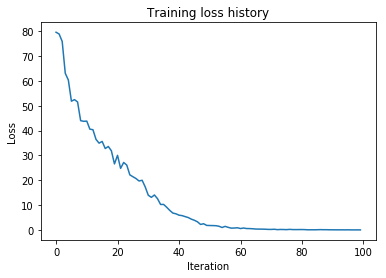

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:431: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


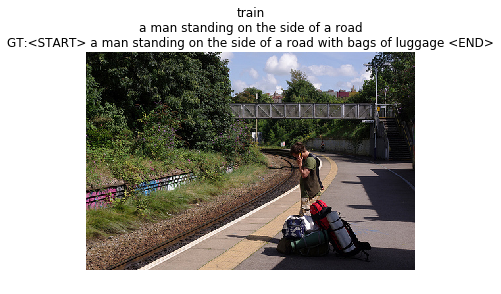

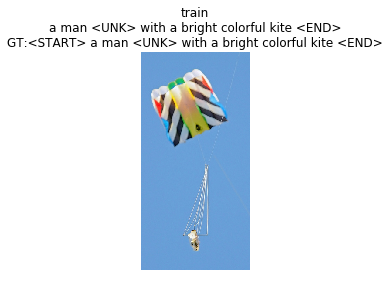

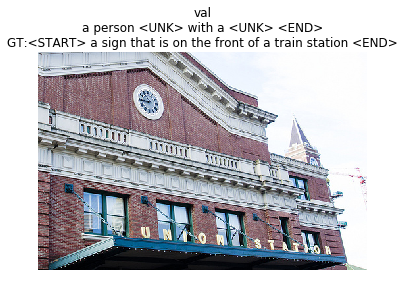

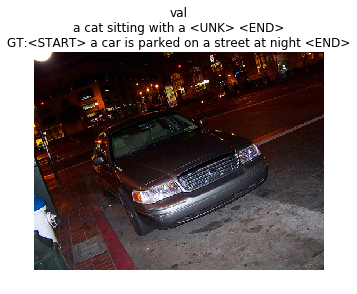

In [18]:
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
        
        
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))


np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_lstm_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()